# Einlesen der FACT Daten


Die Daten sind im HDF5 Format gespeichert und können mit dem Python-Modul h5py eingelesen werden.

Das Python-Modul `pyfact` bietet eine nützliche Funktion, um diese Daten direkt in ein `pandas.DataFrame` einzulesen.

```
$ pip install pyfact
```

In [167]:
from fact.io import read_h5py
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Einlesen mit h5py

In [168]:
f = h5py.File('../data/open_crab_sample_dl3.hdf5')

print('Tables:')
print(*f)

print()
print('Columns in events table')
print(*f['events'])

print()
print('Columns in runs table')
print(*f['runs'])
f.close()

Tables:
events runs

Columns in events table
dec_prediction disp_prediction event_num gamma_energy_prediction gamma_prediction index night pointing_position_az pointing_position_zd ra_prediction run_id theta_deg theta_deg_off_1 theta_deg_off_2 theta_deg_off_3 theta_deg_off_4 theta_deg_off_5 timestamp

Columns in runs table
azimuth declination index night ontime right_ascension run_id run_start run_stop source zenith


In [169]:
#theta_deg = f['events/theta_deg'][:]

#plt.hist(theta_deg**2, bins=30, range=[0, 0.1])
#None

## Daten einlesen mit pyfact

In [170]:
gammas = read_h5py('../data/gamma_test_dl3.hdf5', key='events', columns=[
    'gamma_energy_prediction',
    'gamma_prediction',
    'theta_deg',
    'corsika_event_header_event_number',
    'corsika_event_header_total_energy',
])
#Testdatensatz aus simulierten Daten


gammas_corsika = read_h5py(
    '../data/gamma_corsika_events_1.1.2.hdf5',
    key='corsika_events',
    columns=['total_energy'],
)
# Infos über simulierten Daten


crab_events = read_h5py('../data/open_crab_sample_dl3.hdf5', key='events', columns=[
    'gamma_prediction',
    'gamma_energy_prediction',
    'theta_deg',
    'theta_deg_off_1',
    'theta_deg_off_2',
    'theta_deg_off_3',
    'theta_deg_off_4',
    'theta_deg_off_5',
])
#Messdaten

crab_runs = read_h5py('../data/open_crab_sample_dl3.hdf5', key='runs')

In [171]:
#crab_events.head()

# Limits für theata^2 - Plot

In [172]:
limit_theta = np.sqrt(0.025)
crab_events_pred = crab_events[crab_events.gamma_prediction>0.8]
crab_events_sel = crab_events_pred[crab_events_pred.theta_deg<limit_theta]

gammas_pred = gammas[gammas.gamma_prediction>0.8]
gammas_sel = gammas_pred[gammas_pred.theta_deg < limit_theta]

In [173]:
# Mit diesem limit werden alle events für den theta^2 plot ausgewählt (theta^2 < 0.3)
# Für Berechnungen weiterhin crab_events_sel bzw bkg verwenden
limit_theta_plot = np.sqrt(0.3)
crab_events_pred_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta_plot]
crab_events_pred_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta_plot]
crab_events_pred_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta_plot]
crab_events_pred_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta_plot]
crab_events_pred_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta_plot]

crab_events_sel_plot= crab_events_pred[crab_events_pred.theta_deg < limit_theta_plot]

In [174]:
crab_events_sel_1 = crab_events_pred[crab_events_pred.theta_deg_off_1 < limit_theta]
crab_events_sel_2 = crab_events_pred[crab_events_pred.theta_deg_off_2 < limit_theta]
crab_events_sel_3 = crab_events_pred[crab_events_pred.theta_deg_off_3 < limit_theta]
crab_events_sel_4 = crab_events_pred[crab_events_pred.theta_deg_off_4 < limit_theta]
crab_events_sel_5 = crab_events_pred[crab_events_pred.theta_deg_off_5 < limit_theta]
# mask = (crab_events_pred.theta_deg_off_1 < limit_theta) | (crab_events_pred.theta_deg_off_2 < limit_theta) | (crab_events_pred.theta_deg_off_3 < limit_theta) | (crab_events_pred.theta_deg_off_4 < limit_theta) | (crab_events_pred.theta_deg_off_5 < limit_theta)
# crab_events_sel_all = crab_events_pred[mask]
bkg = pd.concat([crab_events_sel_1, crab_events_sel_2, crab_events_sel_3, crab_events_sel_4, crab_events_sel_5])

# Histogramm der Abstandswinkel

In [175]:
theta_deg_off = []
for i in [1, 2, 3, 4, 5]:
    exec('x = crab_events_pred_{}.theta_deg_off_{}.values'.format(i, i))
    for el in x:
        theta_deg_off.append(el)

250


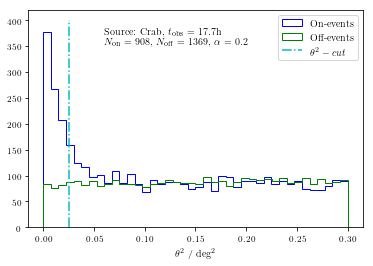

In [176]:
crab_events_sel_on = np.array(crab_events_sel_plot.theta_deg.values)
plt.hist((crab_events_sel_on)**2, bins =40, histtype='step', color='blue', label='On-events')

plt.hist(np.array(theta_deg_off)**2, bins=40, histtype='step', color='g', label='Off-events', weights=np.array([0.2 for el in theta_deg_off]))
plt.vlines(0.025, color='c', linestyle='-.', ymin=0, ymax=400, label=r'$\theta^{2}-cut$')
plt.xlabel(r'$\theta^2$ / $\deg^2$')
plt.legend()
plt.text(0.06, 350,
         r'''Source: Crab, $t_\mathrm{{obs}}$ = 17.7h
        $N_\mathrm{{on}}$ = {non}, $N_\mathrm{{off}}$ = {noff}, $\alpha$ = 0.2'''.format(non=len(crab_events_sel), noff=len(bkg)))

print(len(crab_events_sel_1.theta_deg_off_1.values))

# 2D-Scatterplot der Energien

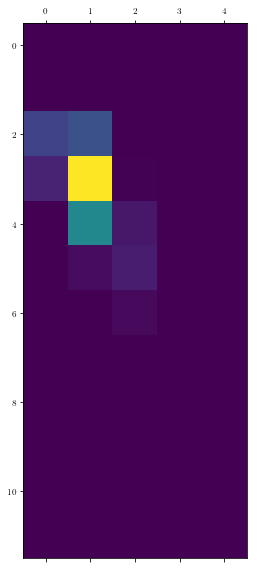

In [248]:
matrix, xedge, yedge = np.histogram2d(
    gammas_sel['gamma_energy_prediction'],
    gammas_sel['corsika_event_header_total_energy'], 
                                         bins=[
                                             np.logspace(np.log10(200),np.log10(50e3),13),
                                             np.logspace(np.log10(200),np.log10(50e3),6),
                                         ],
                                         normed='True')
plt.matshow(matrix)

Text(0, 0.5, 'gamma\\_true\\_energy')

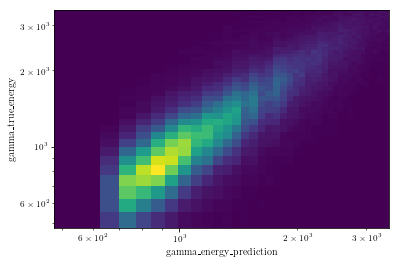

In [244]:
# definiere Grenzquantile für plot
up = np.quantile(gammas['corsika_event_header_total_energy'], 0.9)
low = np.quantile(gammas['corsika_event_header_total_energy'], 0.1)

plt.hist2d(gammas_sel['gamma_energy_prediction'],
                                         gammas_sel['corsika_event_header_total_energy'], 
                                         bins=40, 
                                         normed='True',
                                         range=[[low, up],[low, up]])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('gamma\_energy\_prediction') 
plt.ylabel('gamma\_true\_energy')

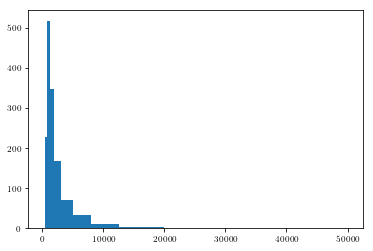

In [249]:
# Untergrund binnen
b, bins, p = plt.hist(bkg['gamma_energy_prediction'], bins=xedge)

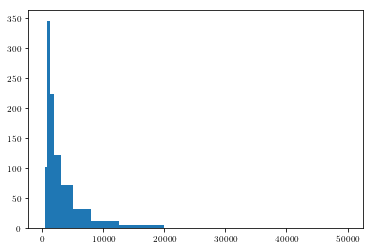

In [250]:
# Signal binnen
g, bins, p = plt.hist(crab_events_sel['gamma_energy_prediction'], bins=xedge)

In [251]:
print(matrix)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.71103120e-08 1.19228172e-07 3.34215405e-11 0.00000000e+00
  0.00000000e+00]
 [4.75471810e-08 4.82695225e-07 3.72131737e-09 1.39842804e-12
  0.00000000e+00]
 [1.62424148e-09 2.24989025e-07 3.18036421e-08 3.26597994e-11
  0.00000000e+00]
 [3.06039481e-11 1.54029622e-08 3.74681320e-08 1.79406976e-10
  0.00000000e+00]
 [0.00000000e+00 4.38582897e-10 1.26415614e-08 6.26352825e-10
  5.82823593e-13]
 [0.00000000e+00 1.81863397e-11 1.34687366e-09 1.08107481e-09
  2.57517549e-12]
 [0.00000000e+00 0.00000000e+00 2.57879185e-11 3.95977592e-10
  1.04029969e-11]
 [0.00000000e+00 0.00000000e+00 5.33688834e-13 6.53603783e-11
  1.76473138e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.81573491e-13
  7.25337031e-12]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  3.73745031e-13]]


In [252]:
# Penrose-Moore Pseudoinverse ausrechnen wegen Singularität
inv = np.linalg.pinv(matrix)
print(inv)

[[-9.69566177e-10 -2.10438452e-10  1.12588553e+07 -1.89539976e+06
  -2.02202547e+06  1.77167739e+06  4.10369753e+05 -4.31627789e+05
  -1.15934096e+05  9.62415898e+04  5.22497899e+04  2.71189644e+03]
 [ 3.45067531e-10  8.28231189e-11 -1.00917331e+06  2.03927861e+06
   6.53145870e+05 -7.08431351e+05 -1.59647751e+05  1.73090410e+05
   4.62849291e+04 -3.86342530e+04 -2.09552797e+04 -1.08760932e+03]
 [-2.97283189e-09 -1.86332071e-09  2.87479070e+06 -6.24771369e+06
   1.06870884e+07  1.73487005e+07  3.12545395e+06 -4.63187404e+06
  -1.19110754e+06  1.04343652e+06  5.61483396e+05  2.91365259e+04]
 [-8.47540052e-08  3.87126957e-08 -2.42485290e+07  5.28735946e+07
  -9.67642485e+07 -6.66463925e+07  3.51436041e+08  6.92176282e+08
   1.44839615e+08 -1.63114168e+08 -8.46364746e+07 -4.38823732e+06]
 [-7.78364022e-08  1.66569901e-06  3.60280979e+08 -7.85966754e+08
   1.45295124e+09  7.69886888e+08 -5.03487637e+09 -6.68935655e+09
   1.91825631e+10  3.96567928e+10  1.66058978e+10  8.56126362e+08]]


Unfolded: [-9.09674281e+08 -2.74138942e+08 -1.35394369e+09  8.24912273e+09
 -2.22862373e+10]
 shape (5,)


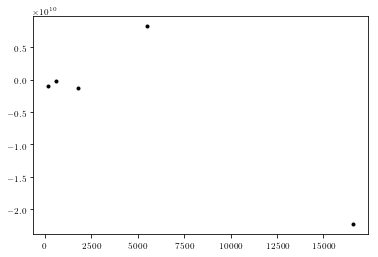

In [253]:
# Naive Entfaltung
ev = g-b
print('Unfolded: {}\n shape {}'.format(inv.dot(ev), np.shape(inv.dot(ev))))
plt.plot(yedge[:-1], inv.dot(ev), 'k.')